# Feature Contributions Documentation

This notebook is designed to demonstrate how to use `mintpy` to compute feature contributions using SHAP (link) or treeinterpreter (link) and plot the results. For more information on dataset and initializing `InterpretToolkit`, see the permutatation importance notebook.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import mintpy
import plotting_config 
import shap

### Loading the training data and pre-fit models 

In [3]:
model_objs, model_names = mintpy.load_models()
examples, targets = mintpy.load_data()

### Tree Interpreter-Based Feature Contribution (Single Example)

For decision trees models trained from the scikit-learn package, we can calculate feature contributions using the treeinterpreter method. The idea is that starting from the climatological event frequency of a dataset (AKA the "bias", 39% in our case), each split made in the decision path adds to or substracts from the bias to produce the final prediction. For an ensemble method like random forests, we can compute the contributions per tree and then take the ensemble average contribution. In our first example, we can get the contribution break-down for a single example for the random forest model (tree interpreter doesn't work for gradient-boosted models).

OrderedDict([('Random Forest', RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5))]) ['Random Forest']


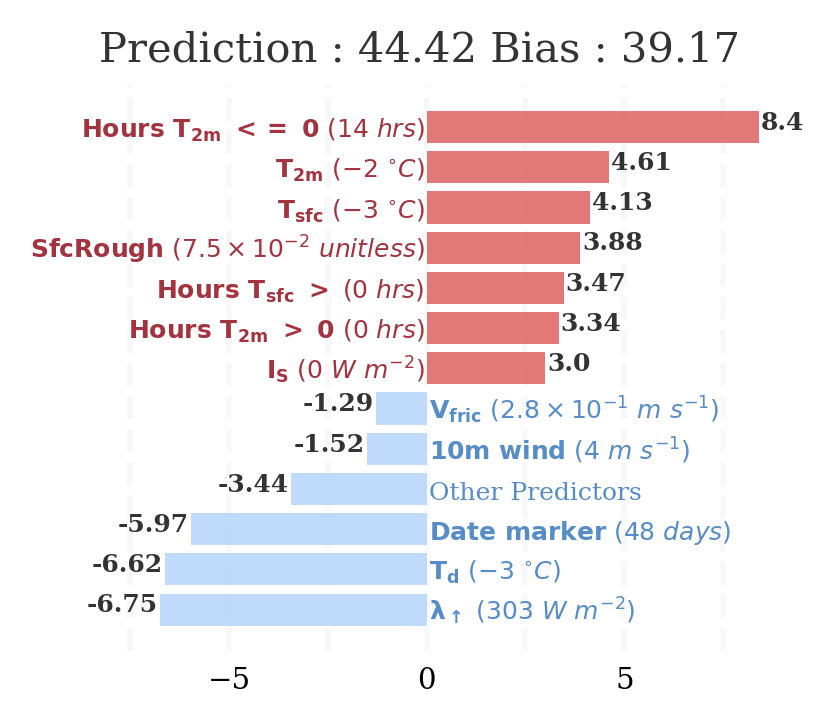

In [4]:
single_example = examples.iloc[[0]]
myInterpreter = mintpy.InterpretToolkit(models=model_objs[0],
                                 model_names=model_names[0],
                                 examples=single_example,
                                 targets=targets,
                                )
results = myInterpreter.calc_contributions(method='tree_interpreter')                                        
fig = myInterpreter.plot_contributions(
    display_feature_names=plotting_config.display_feature_names,
    display_units = plotting_config.display_units,
)

`Final Pred` is the final prediction for this example while `Bias` is the bias. The idea is that the summation of the contributions plus the bias will equal the final prediction. For this particular example, there are competing effects. 

## Tree Interpreter-Based Feature Contribution (Performance-Based)

Although it can be important to assess the breakdown of a single prediction, we can also summarize feature contributions over several examples. By setting `performance_based=True`, we can summarize feature contributions for the top and worst performers. The number of examples to compute these summarized statistics is given by `n_examples`. In this case, we want to summarize the contributions over top 100 best and worst performing examples. 

__Note__: "Hits" and "Misses" are defined as a set of predictions being close to or far from the target variables (binary or regression), respectively, and "Correct Negatives (Corr Negs)" and "False Alarms" are defined as a set of predictions being close to or far from the 


OrderedDict([('Random Forest', RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5))]) ['Random Forest']


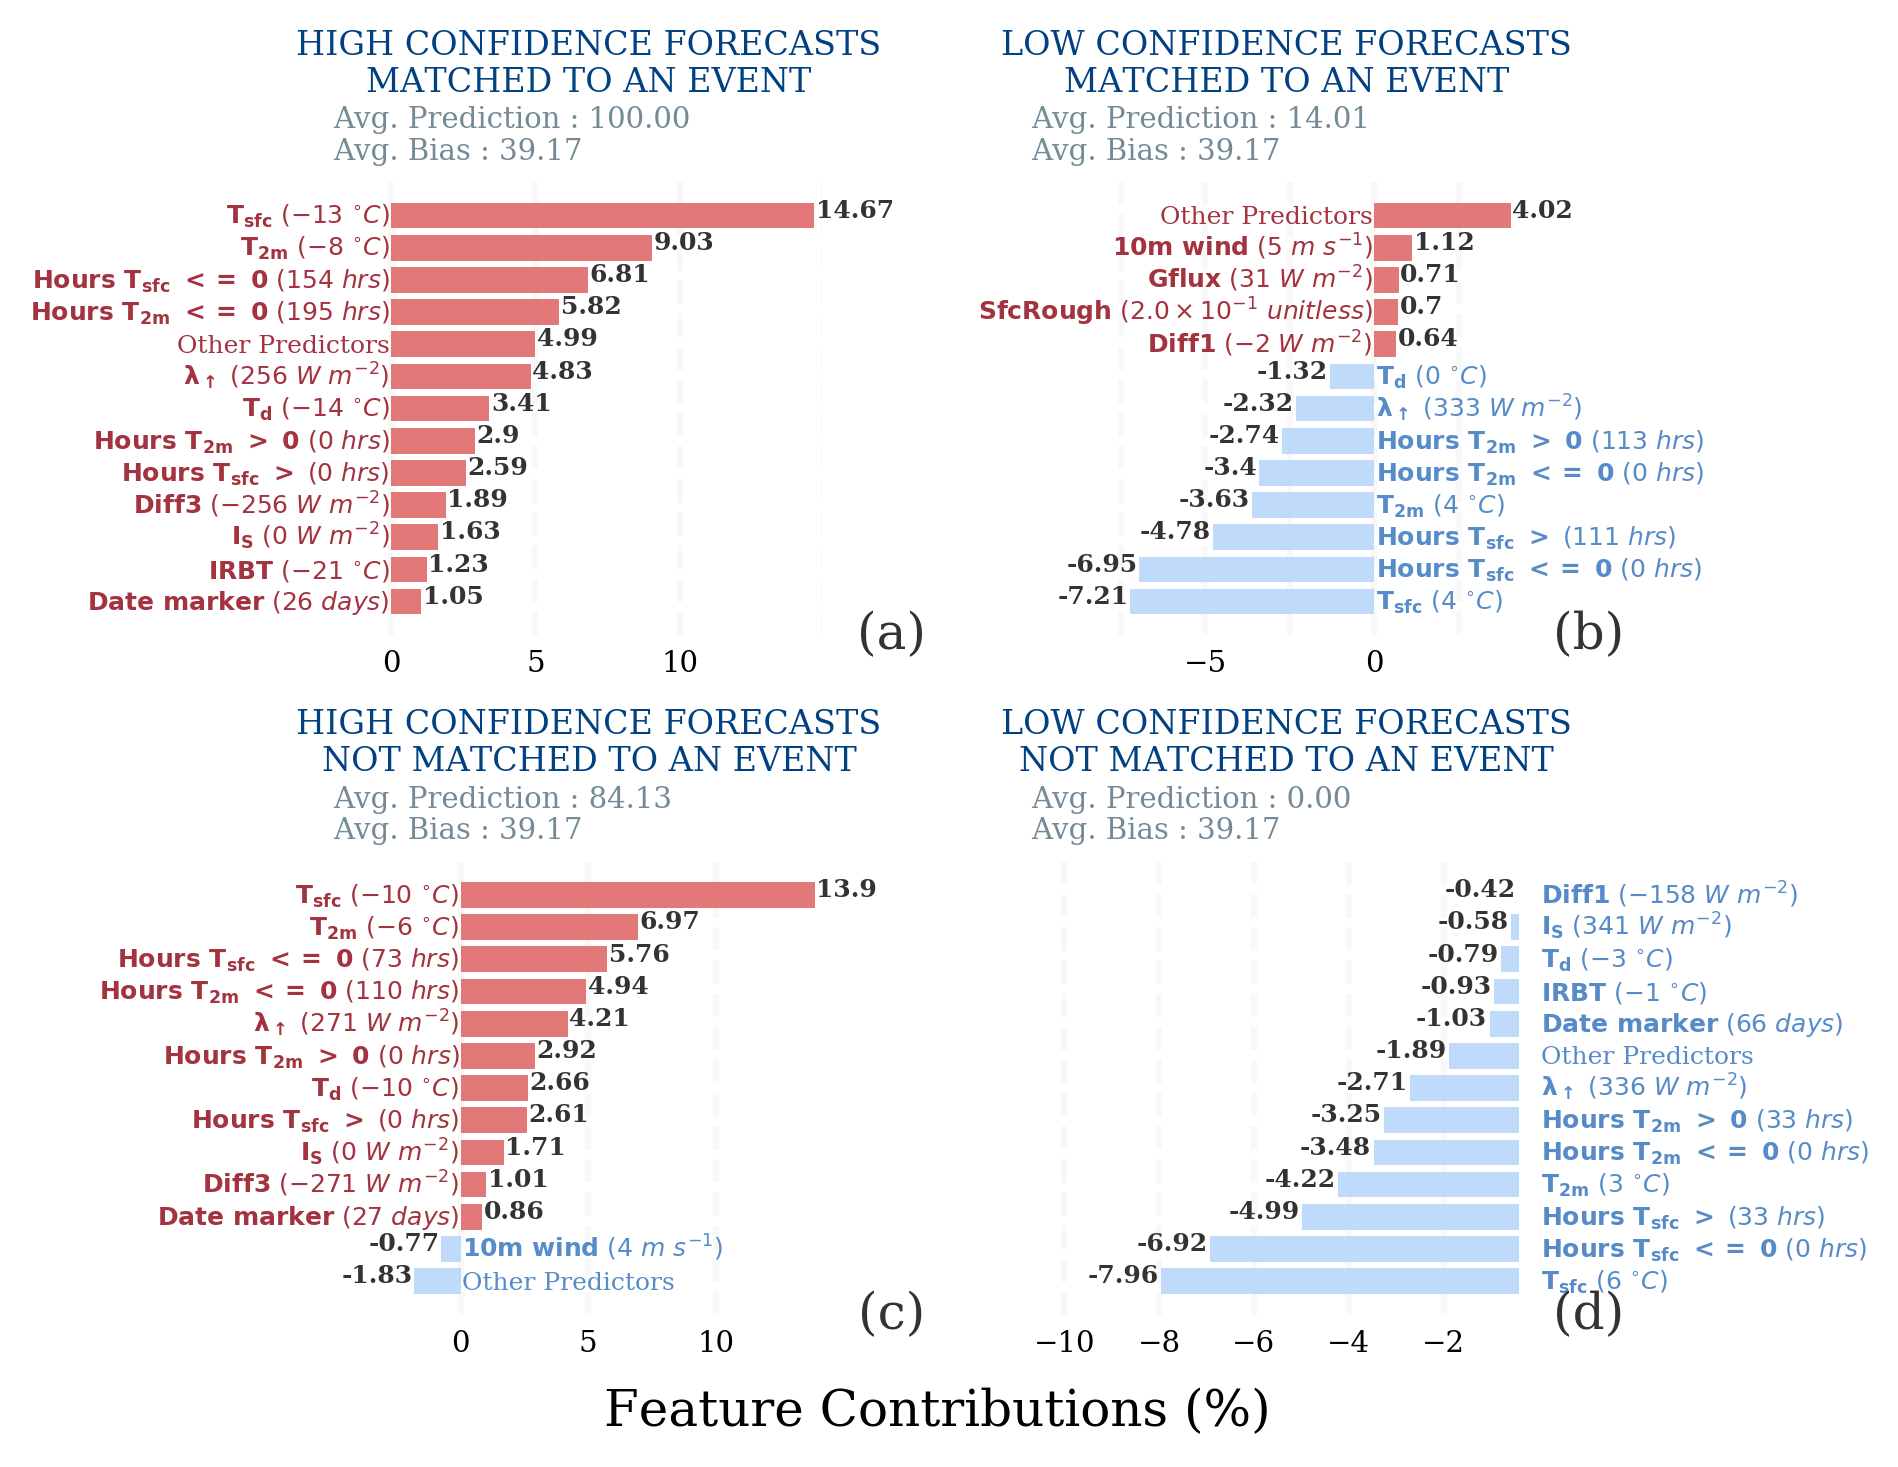

In [5]:
myInterpreter = mintpy.InterpretToolkit(models=model_objs[0],
                                 model_names=model_names[0],
                                 examples=examples,
                                 targets=targets,
                                )
results = myInterpreter.calc_contributions(method='tree_interpreter', 
                                           performance_based=True,
                                          n_examples=10)

fig = myInterpreter.plot_contributions(display_feature_names=plotting_config.display_feature_names,
                                      display_units = plotting_config.display_units,)

### SHAP-based Feature Contributions (Single Example)

A better method with model-agnostic capabilities is __SHAP (SHapley Additive exPlanations)__ (https://github.com/slundberg/shap; https://christophm.github.io/interpretable-ml-book/shap.html). SHAP uses game theoretic approach to explain the output of any machine learning model. 

OrderedDict([('Random Forest', RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5))]) ['Random Forest']
trying TreeExplainer...


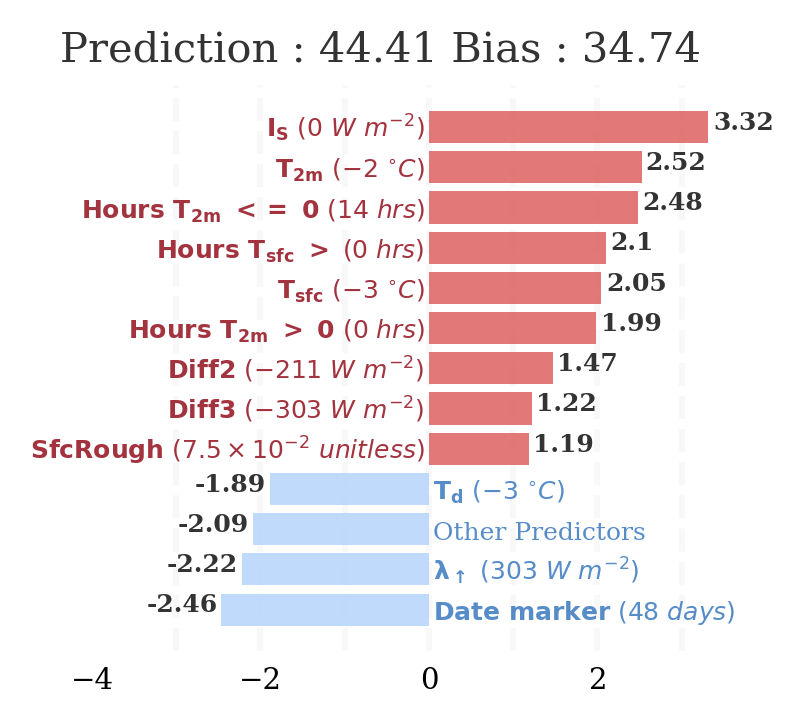

In [6]:
single_example = examples.iloc[[0]]
myInterpreter = mintpy.InterpretToolkit(models=model_objs[0],
                                 model_names=model_names[0],
                                 examples=single_example,
                                 targets=targets,
                                )

background_dataset = shap.sample(examples, 100)

results = myInterpreter.calc_contributions(method='shap', 
                                           background_dataset=background_dataset)

fig = myInterpreter.plot_contributions(to_only_varname=None, 
                                     display_feature_names=plotting_config.display_feature_names,
                                       display_units = plotting_config.display_units,
                                )

### SHAP-based Feature Contributions (Performance-based)

OrderedDict([('Random Forest', RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5))]) ['Random Forest']
trying TreeExplainer...


 99%|===================| 198/200 [00:48<00:00]        

trying TreeExplainer...


 98%|===================| 195/200 [00:40<00:01]        

trying TreeExplainer...


 99%|===================| 198/200 [00:47<00:00]        

trying TreeExplainer...


100%|===================| 199/200 [00:40<00:00]        

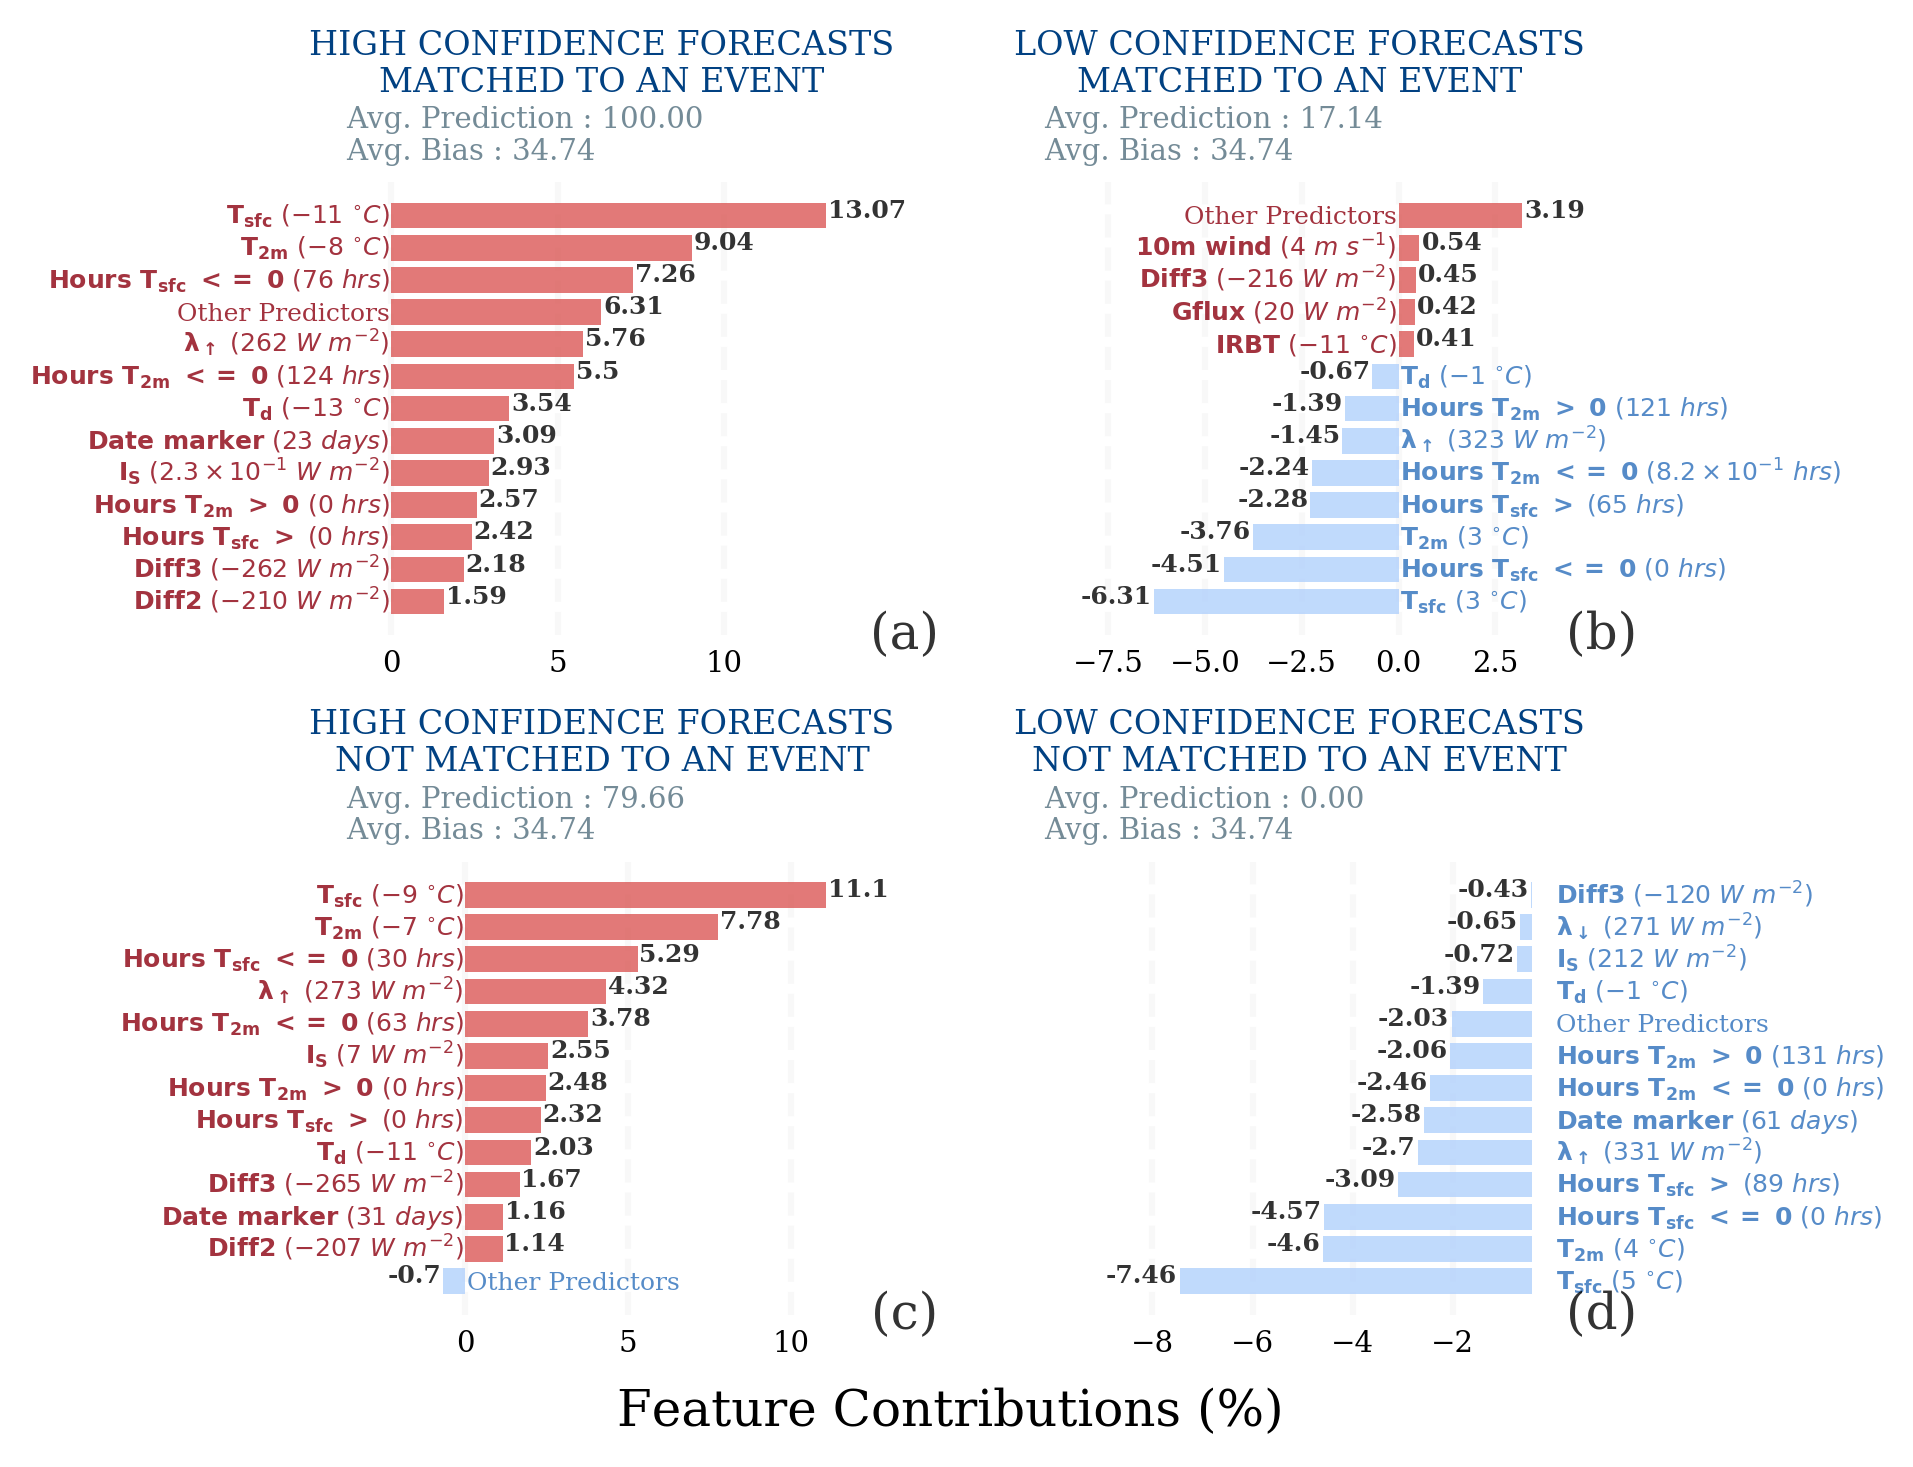

In [7]:
del myInterpreter
myInterpreter = mintpy.InterpretToolkit(models=model_objs[0],
                                 model_names=model_names[0],
                                 examples=examples,
                                 targets=targets,
                                )
results = myInterpreter.calc_contributions(method='shap', 
                                           background_dataset=background_dataset,
                                           performance_based=True,
                                          )

fig = myInterpreter.plot_contributions(to_only_varname=None, 
                                      display_feature_names=plotting_config.display_feature_names,
                                       display_units = plotting_config.display_units,
                                )

## Feature Contributions for Regression Problems

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [9]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
clf = RandomForestRegressor()
clf.fit(X,y)

RandomForestRegressor()

In [10]:
myInterpreter = mintpy.InterpretToolkit(models=clf,
                                 model_names='Random Forest',
                                 examples=X,
                                 targets=y,
                                 feature_names = feature_names
                                )

OrderedDict([('Random Forest', RandomForestRegressor())]) ['Random Forest']


trying TreeExplainer...
TreeExplainer failed, starting KernelExplainer...



trying TreeExplainer...


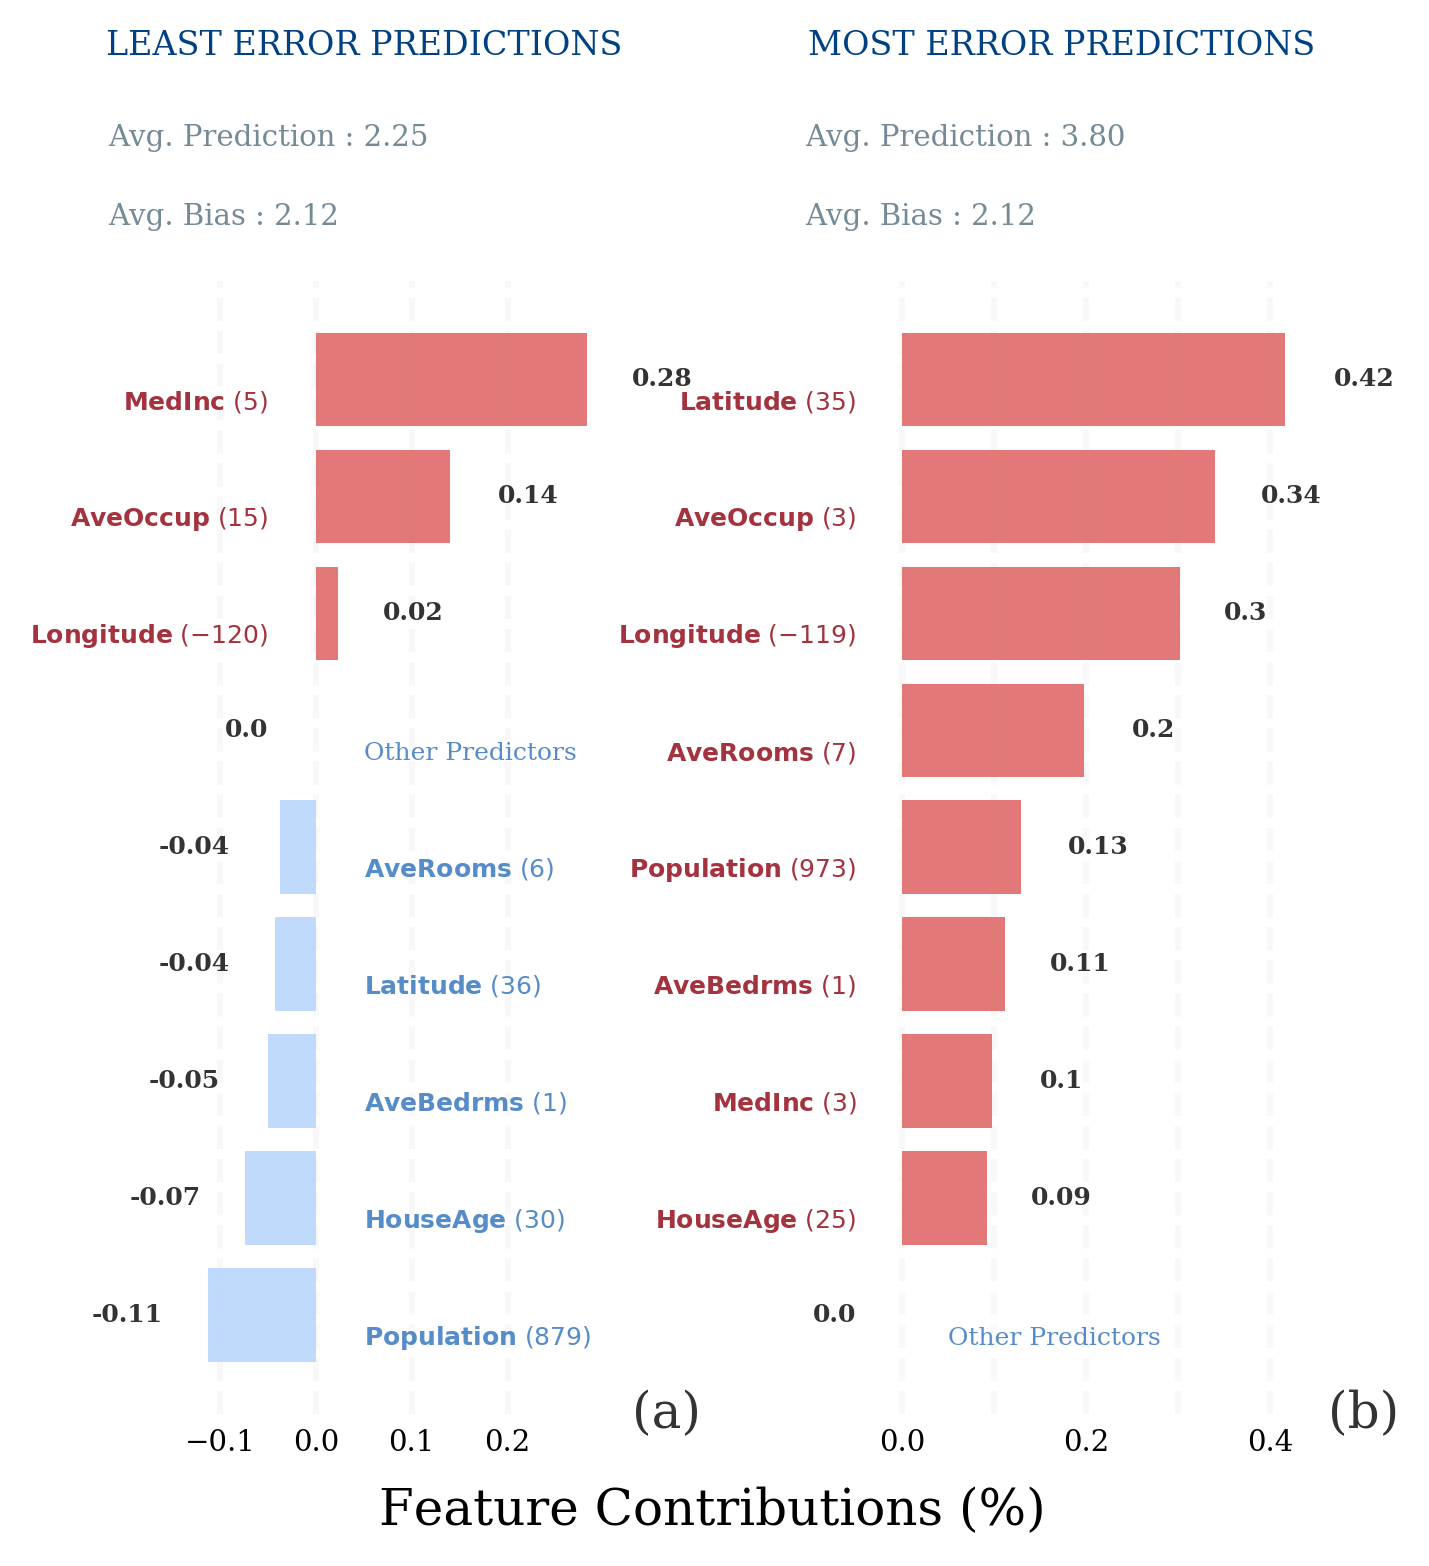

In [11]:
background_dataset = shap.sample(X, 100)
results = myInterpreter.calc_contributions(method='shap', 
                                           background_dataset=background_dataset,
                                           performance_based=True,
                                          )

fig = myInterpreter.plot_contributions()